# Autoencoder for time series

## Notebook settings

In [1]:
%config IPCompleter.greedy=True
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
dataset_name = 'ECG200'
data_directory = '../data/UCRArchive_2018'
checkpoints_directory = 'checkpoints'

## Get data and divide in training and test set

In [3]:
import numpy as np

In [4]:
# %load -s loadData ../scripts/dataUtilities.py 
def loadData(direc, dataset, perm=True, ratio_train=0.8):
    datadir = direc + '/' + dataset + '/' + dataset
    data_train = np.genfromtxt(datadir + '_TRAIN.tsv', delimiter='\t')
    data_test_val = np.genfromtxt(datadir + '_TEST.tsv', delimiter='\t')
    data = np.concatenate((data_train, data_test_val), axis=0)

    N, D = data.shape
    ind_cut = int(ratio_train * N)
    if perm:
        ind = np.random.permutation(N)
    else:
        ind = range(0, N)
    return data[ind[:ind_cut], 1:], data[ind[ind_cut:], 1:], data[ind[:ind_cut], 0], data[ind[ind_cut:], 0]


In [5]:
dataTrain, dataTest, labelsTrain, labelsTest = loadData(data_directory, dataset_name)

# Data Profiling

In [6]:
import pandas as pd

In [7]:
# Building again the dataset
all_data = np.concatenate((dataTrain, dataTest))
all_labels = np.concatenate((labelsTrain, labelsTest)).reshape(-1, 1)
all_dataset = np.concatenate((all_labels, all_data), axis=1)

pd.DataFrame(all_data).plot(legend=False, title="All data");
all_dataset_df = pd.DataFrame(all_dataset)
all_dataset_df.head()
all_dataset_df.describe()
all_dataset_df.isnull().sum().sum()
all_dataset_df.groupby([0]).count()

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,1.0,0.959307,2.248694,3.659097,2.826003,2.248551,0.864185,-1.000386,0.208861,0.453553,...,-0.650075,-0.933816,-0.702941,-0.658564,-0.749179,-0.456274,-0.945492,-0.814490,-0.768347,-0.887685
1,1.0,0.147647,0.804668,0.367771,0.243894,0.026614,-0.274402,0.096731,-0.747731,-1.609777,...,-0.533503,-0.400228,0.176084,1.111768,2.438428,2.734889,1.736054,0.036857,-1.265074,-0.208024
2,1.0,0.597829,1.257428,2.758496,4.086991,2.452211,0.816636,-0.776343,-0.503964,0.587363,...,-0.370074,-0.074982,-0.213822,-0.132811,-0.216828,-0.346576,-0.014023,-0.184166,-0.176845,-0.119220
3,2.0,0.533117,1.039520,1.755770,2.765948,3.137922,2.753190,1.781773,0.701843,1.064610,...,0.079920,0.076563,0.058677,0.055115,0.241752,0.069938,0.232553,0.082874,0.267488,0.144952
4,1.0,0.069192,1.279248,2.731827,2.871786,2.305235,0.779556,-0.736634,-0.170404,0.522676,...,-0.062467,0.030928,-0.155869,-0.232819,-0.128906,-0.021520,-0.007046,-0.118996,-0.076081,0.045271


,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,1.335000,0.743272,1.421336,1.984988,2.057093,1.491614,0.731119,0.232361,0.257093,0.320649,...,0.177761,0.169668,0.216420,0.320468,0.423468,0.434603,0.392500,0.286076,0.178387,0.178010
std,0.473175,0.656504,0.933899,1.099837,1.145900,1.037496,1.072901,1.191892,0.992507,0.848561,...,0.399908,0.440024,0.485063,0.653668,0.796140,0.853983,0.819796,0.683973,0.600855,0.412488
min,1.000000,-1.668193,-2.053335,-2.235332,-2.173837,-1.741502,-1.645442,-1.962966,-2.238767,-2.071550,...,-0.741970,-0.933816,-0.702941,-0.658564,-0.749179,-0.586938,-0.953753,-1.061242,-2.023361,-1.376014
25%,1.000000,0.351854,0.801944,1.236955,1.519871,0.878374,-0.103273,-0.797398,-0.545180,-0.131242,...,-0.127239,-0.166357,-0.139094,-0.135534,-0.091210,-0.098634,-0.121569,-0.135458,-0.148239,-0.029921
50%,1.000000,0.602270,1.317324,2.148766,2.211722,1.758979,0.565551,0.102541,0.243512,0.383503,...,0.097707,0.094129,0.105080,0.129133,0.164093,0.137404,0.101618,0.136106,0.156895,0.203341
75%,2.000000,1.088079,2.096139,2.735496,2.834215,2.260736,1.583881,1.217154,1.005584,0.939848,...,0.444616,0.487631,0.543325,0.588580,0.587246,0.630966,0.593357,0.562311,0.587750,0.441094
max,2.000000,2.689017,3.535038,3.871794,4.199145,3.720899,3.075674,2.811203,2.453287,2.290844,...,1.376751,1.497244,2.317878,2.916254,3.339119,3.294043,3.349601,2.883938,2.025593,1.372607


0

,1,2,3,4,5,6,7,8,9,10,...,87,88,89,90,91,92,93,94,95,96
0,,,,,,,,,,,,,,,,,,,,,
1.0,133,133,133,133,133,133,133,133,133,133,...,133,133,133,133,133,133,133,133,133,133
2.0,67,67,67,67,67,67,67,67,67,67,...,67,67,67,67,67,67,67,67,67,67


## Cleaning and plotting data

In [8]:
# %load -s outlier_annihilation ../scripts/dataUtilities.py 
def outlier_annihilation(df):
    for col in df:
        low_threshold = df[col].quantile(0.03)
        high_threshold = df[col].quantile(0.97)
        df.loc[df[col] < low_threshold, col] = low_threshold
        df.loc[df[col] > high_threshold, col] = high_threshold
    return df.to_numpy()


### Cleaning training data

Populating the interactive namespace from numpy and matplotlib


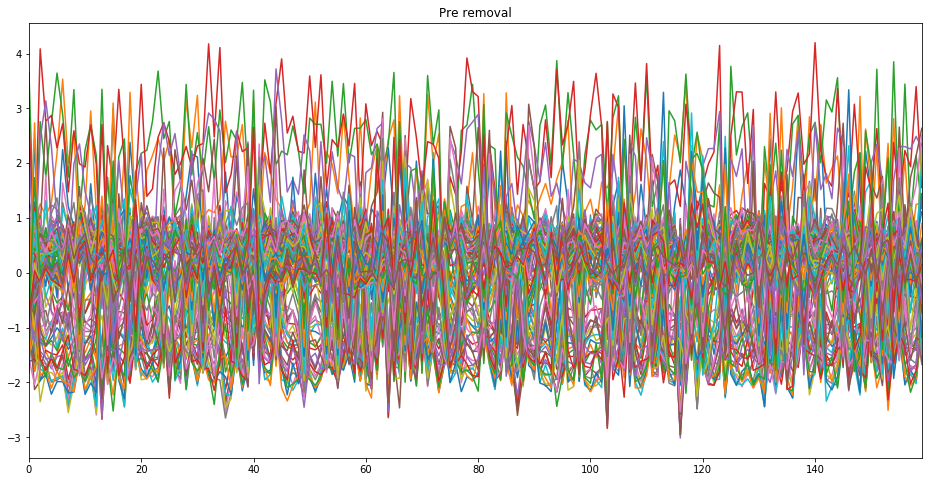

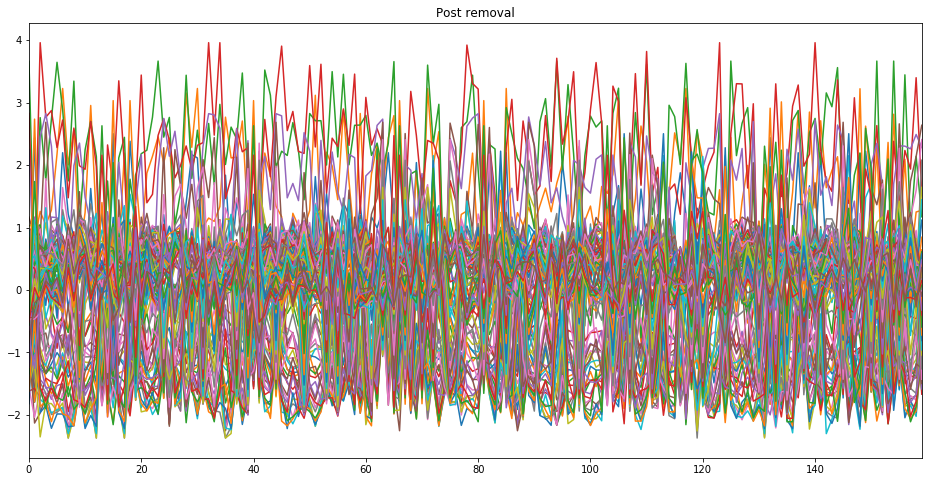

In [9]:
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 8)

dataTrain_df = pd.DataFrame(dataTrain)
dataTrain_df.plot(legend=False, title="Pre removal");
dataTrain_clean = outlier_annihilation(dataTrain_df)
pd.DataFrame(dataTrain_clean).plot(legend=False, title="Post removal");

### Cleaning test data

Populating the interactive namespace from numpy and matplotlib


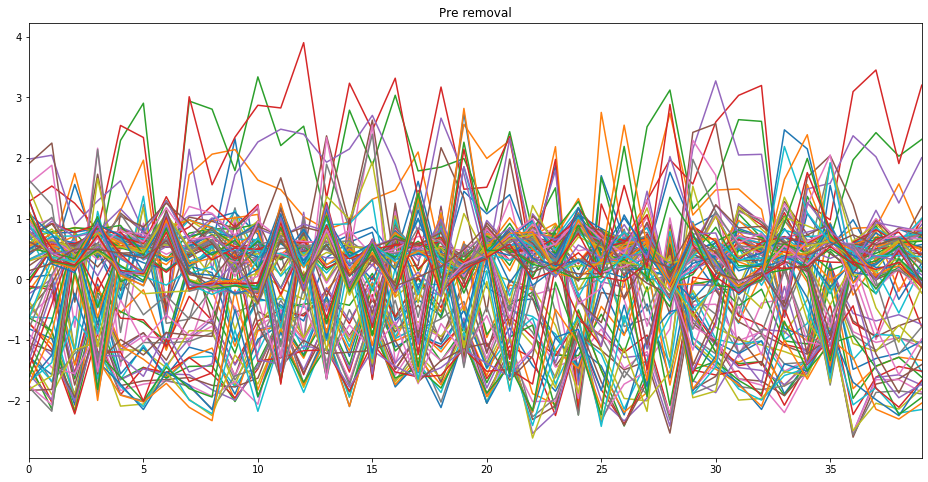

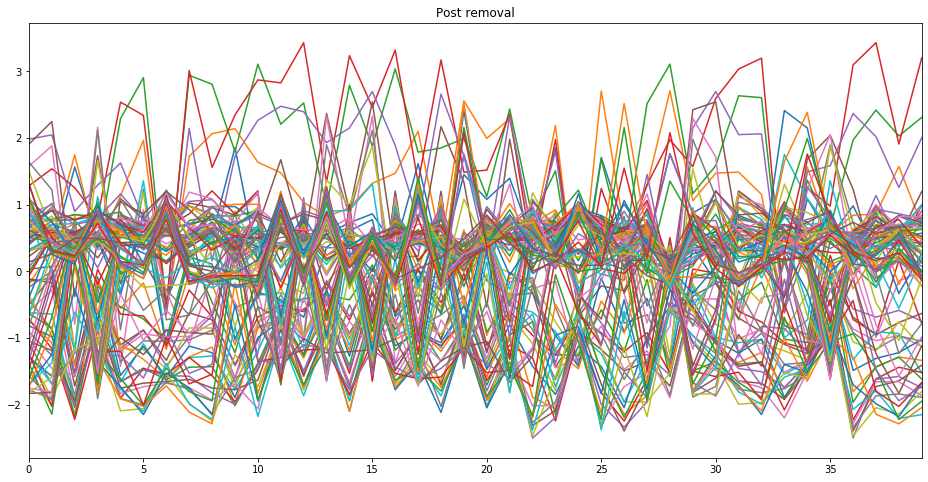

In [10]:
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 8)

dataTest_df = pd.DataFrame(dataTest)
dataTest_df.plot(legend=False, title="Pre removal");
dataTest_clean = outlier_annihilation(dataTest_df)
pd.DataFrame(dataTest_clean).plot(legend=False, title="Post removal");

## Data description

In [11]:
N = dataTrain_clean.shape[0]
Nval = dataTest_clean.shape[0]
D = dataTrain_clean.shape[1]
sl = D  # Time series sequence length
print('Train set samples: %s ' % (N+1))
print('Test set samples: %s ' % (Nval))
print('Dimensions (columns): %s ' % (D))

Train set samples: 161 
Test set samples: 40 
Dimensions (columns): 96 


## Valuate class number and min class

In [12]:
num_classes = len(np.unique(labelsTrain))
base = np.min(labelsTrain)  # Check if data is 0-based
if base != 0:
    labelsTrain -= base
    labelsTest -= base

print('We have %s classes, %s is the min class value' % (num_classes, base))

We have 2 classes, 1.0 is the min class value


In [13]:
import matplotlib.pyplot as plt
from collections import Counter

In [14]:
# %load -s plot_data ../scripts/plotUtilities.py 
def plot_data(data, classes, plot_row=10, save = False, name = 'tmp', adjust=True):
    counts = dict(Counter(classes))
    uniqueClasses = np.unique(classes)
    num_classes = len(uniqueClasses)
    f, axarr = plt.subplots(plot_row, num_classes)
    for selectedClass in uniqueClasses:  # Loops over classes, plot as columns
        selectedClass = int(selectedClass)
        ind = np.where(classes == selectedClass)
        ind_plot = np.random.choice(ind[0], size=plot_row)
        for n in range(plot_row):  # Loops over rows
            # Only shops axes for bottom row and left column
            if n == 0:
                axarr[n, selectedClass].set_title('Class %.0f (%.0f elements)' % (selectedClass + 1, counts[float(selectedClass)]))
            if n < counts[float(selectedClass)]:
                axarr[n, selectedClass].plot(data[ind_plot[n], :])

                if not n == plot_row - 1:
                    plt.setp([axarr[n, selectedClass].get_xticklabels()], visible=False)
                if not selectedClass == 0:
                    plt.setp([axarr[n, selectedClass].get_yticklabels()], visible=False)
    
    if adjust == True:
        f.subplots_adjust(hspace=0)  # No horizontal space between subplots
        f.subplots_adjust(wspace=0)  # No vertical space between subplots
    plt.show()

    if save:
        plt.savefig(name, format='png', dpi=1000)
        
    return


## Data class plot

Populating the interactive namespace from numpy and matplotlib


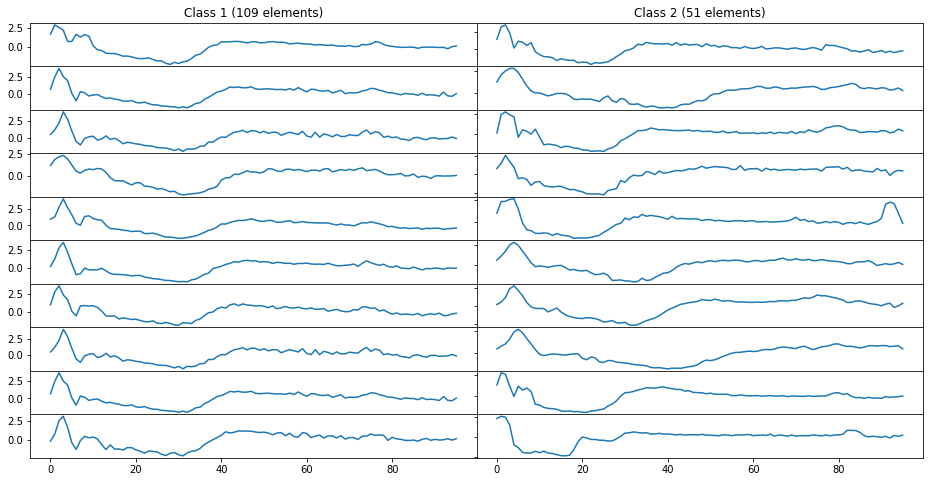

In [15]:
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 8)

plot_data(dataTrain, labelsTrain)
# plot_data(dataTrain, labelsTrain, 5, True, "Prova.eps")

# Training time

## Configuration hyperparameter

In [16]:
plot_every = 100  # after _plot_every_ GD steps, there's console output
max_iterations = 1000  # maximum number of iterations
dropout = 0.8 # Dropout rate

dataset_configs = {
    'ECG5000': {
        'num_layers': 2,  # number of layers of stacked RNN's
        'hidden_size': 90,  # memory cells in a layer
        'max_grad_norm': 5,  # maximum gradient norm during training
        'batch_size': 64, # number of samples for iteration
        'learning_rate': .005, # for exponential decay
        'crd': 1,  # Hyperparameter for future generalization
        'num_l': 32 # number of units in the latent space
    },
    'ECG200': {
        'num_layers': 2,
        'hidden_size': 90,
        'max_grad_norm': 5,
        'batch_size': 32,
        'learning_rate': .005,
        'crd': 1,
        'num_l': 32
    },
    'ChlorineConcentration': {
        'num_layers': 2,
        'hidden_size': 90,
        'max_grad_norm': 5,
        'batch_size': 64,
        'learning_rate': .005,
        'crd': 1,
        'num_l': 32
    },
    'FordA': {
        'num_layers': 2,
        'hidden_size': 90,
        'max_grad_norm': 5,
        'batch_size': 64,
        'learning_rate': .005,
        'crd': 1,
        'num_l': 32
    },
    'FordB': {
        'num_layers': 2,
        'hidden_size': 90,
        'max_grad_norm': 5,
        'batch_size': 64,
        'learning_rate': .005,
        'crd': 1,
        'num_l': 32
    },
    'PhalangesOutlinesCorrect': {
        'num_layers': 2,
        'hidden_size': 90,
        'max_grad_norm': 5,
        'batch_size': 64,
        'learning_rate': .005,
        'crd': 1,
        'num_l': 32
    },
    'RefrigerationDevices': {
        'num_layers': 2,
        'hidden_size': 90,
        'max_grad_norm': 5,
        'batch_size': 64,
        'learning_rate': .005,
        'crd': 1,
        'num_l': 32
    },
    'TwoLeadECG': {
        'num_layers': 2,
        'hidden_size': 90,
        'max_grad_norm': 5,
        'batch_size': 16,
        'learning_rate': .001,
        'crd': 1,
        'num_l': 32
    },
    'TwoPatterns': {
        'num_layers': 2,
        'hidden_size': 90,
        'max_grad_norm': 5,
        'batch_size': 64,
        'learning_rate': .005,
        'crd': 1,
        'num_l': 32
    }
}
config = dataset_configs[dataset_name]
config['sl'] = sl;  # Time series sequence length
config

{'num_layers': 2,
 'hidden_size': 90,
 'max_grad_norm': 5,
 'batch_size': 32,
 'learning_rate': 0.005,
 'crd': 1,
 'num_l': 32,
 'sl': 96}

# Model definition

### Net description
**dropout**: A single model can be used to simulate having a large number of different network architectures by randomly dropping out nodes during training. This is called dropout and offers a very computationally cheap and remarkably effective regularization method to reduce overfitting and improve generalization error in deep neural networks of all kinds.


In [17]:
import tensorflow as tf
from tensorflow.keras.layers import LSTMCell
import tensorflow_probability as tfp

In [18]:
class Model:
    def __init__(self, config):
        # Hyperparameters of the net
        num_layers = config['num_layers']
        hidden_size = config['hidden_size']
        max_grad_norm = config['max_grad_norm']
        batch_size = config['batch_size']
        sl = config['sl']
        crd = config['crd']
        num_l = config['num_l']
        learning_rate = config['learning_rate']
        self.sl = sl
        self.batch_size = batch_size

        # Nodes for the input variables
        self.x = tf.placeholder("float", shape=[batch_size, sl], name='Input_data')
        self.x_exp = tf.expand_dims(self.x, 1)
        self.keep_prob = 1 - dropout
        
        with tf.variable_scope("Encoder", reuse=tf.AUTO_REUSE):
            # The encoder cell, multi-layered with dropout
            # Number of LSTM = hidden layer size
            cell_enc = tf.keras.layers.StackedRNNCells([
                tf.keras.layers.LSTMCell(
                    hidden_size,
                    dropout=self.keep_prob
                ) for _ in range(num_layers)
            ])
            # Initial state, tuple for all lstms stacked
            # layer for mean of z
            W_mu = tf.get_variable('W_mu', [hidden_size, num_l])

            # Creates a recurrent neural network specified by RNNCell cell
            # outputs is a length T list of outputs (one for each input), or a nested tuple of such elements.
            # in our case one output for each time series in input
            stacked_layer = tf.keras.layers.RNN(cell_enc, unroll=True)

            cell_output = stacked_layer(self.x_exp)
            b_mu = tf.get_variable('b_mu', [num_l])

            # self.z_mu is the Tensor containing the hidden representations
            # It can be used to do visualization, clustering or subsequent classification
            # tf.nn.xw_plus_b computes matmul(x, weights) + biases.
            self.z_mu = tf.nn.xw_plus_b(cell_output, W_mu, b_mu, name='z_mu')  # mu, mean, of latent space

            # Calculate the mean and variance of the latent space
            # The mean and variance are calculated by aggregating the contents of z_mu across axes
            lat_mean, lat_var = tf.nn.moments(self.z_mu, axes=[1])

            # Train the point in latent space to have zero-mean and unit-variance on batch basis
            self.loss_lat_batch = tf.reduce_mean(tf.square(lat_mean) + lat_var - tf.log(lat_var) - 1)

        with tf.name_scope("Lat_2_dec"):
            # layer to generate initial state
            W_state = tf.get_variable('W_state', [num_l, hidden_size])
            b_state = tf.get_variable('b_state', [hidden_size])
            z_state = tf.nn.xw_plus_b(self.z_mu, W_state, b_state, name='z_state')  # mu, mean, of latent space

        # Similar steps as encoder
        with tf.variable_scope("Decoder"):
            # The decoder, also multi-layered
            cell_dec = tf.contrib.rnn.MultiRNNCell([LSTMCell(hidden_size) for _ in range(num_layers)])

            # Initial state
            initial_state_dec = tuple([(z_state, z_state)] * num_layers)
            dec_inputs = [tf.zeros([batch_size, 1])] * sl

            outputs_dec, _ = tf.contrib.rnn.static_rnn(cell_dec,
                                                       inputs=dec_inputs,
                                                       initial_state=initial_state_dec)
        with tf.name_scope("Out_layer"):
            params_o = 2 * crd  # Number of coordinates + variances
            W_o = tf.get_variable('W_o', [hidden_size, params_o])
            b_o = tf.get_variable('b_o', [params_o])
            outputs = tf.concat(outputs_dec, axis=0)  # tensor in [sl*batch_size,hidden_size]
            h_out = tf.nn.xw_plus_b(outputs, W_o, b_o)
            h_mu, h_sigma_log = tf.unstack(tf.reshape(h_out, [sl, batch_size, params_o]), axis=2)
            h_sigma = tf.exp(h_sigma_log)
            dist = tfp.distributions.Normal(h_mu, h_sigma)
            px = dist.log_prob(tf.transpose(self.x))
            loss_seq = -px
            self.loss_seq = tf.reduce_mean(loss_seq)

        with tf.name_scope("train"):
            global_step = tf.Variable(0, trainable=False)
            # Use learning rate decay
            # Useful use a learning rate schedule to reduce learning rate as the training progresses. 
            lr = tf.train.exponential_decay(learning_rate, global_step, 1000, 0.1, staircase=False)

            self.loss = self.loss_seq + self.loss_lat_batch

            # Route the gradients
            tvars = tf.trainable_variables()
            # We clip the gradients to prevent explosion
            grads = tf.gradients(self.loss, tvars)
            grads, _ = tf.clip_by_global_norm(grads, max_grad_norm)
            self.numel = tf.constant([[0]])

            # And apply the gradients
            optimizer = tf.train.AdamOptimizer(lr)
            gradients = zip(grads, tvars)
            self.train_step = optimizer.apply_gradients(gradients, global_step=global_step)

            self.numel = tf.constant([[0]])
            
        tf.summary.tensor_summary('lat_state', self.z_mu)
        # Define one op to call all summaries
        self.merged = tf.summary.merge_all()
        # Returns an Op that initializes global variables.
        self.init_op = tf.global_variables_initializer()

## Training model

In [19]:
import tensorflow as tf
import datetime, os

os.makedirs(checkpoints_directory, exist_ok=True)

In [ ]:
model = Model(config)
sess = tf.Session()
perf_collect = np.zeros((2, int(np.ceil(max_iterations / plot_every)+1)))

batch_size = config['batch_size']
# Needed later for testing K-means
actual_test_size = (Nval // batch_size) * batch_size
actual_dataTest = dataTest_clean[0:actual_test_size]
actual_labelsTest = labelsTest[0:actual_test_size]

# Start of the train
epochs = np.floor(batch_size * max_iterations / N)

print('Train with approximately %d epochs' % epochs)

sess.run(model.init_op)

step = 0  # Step is a counter for filling the numpy array perf_collect
for i in range(max_iterations):
    batch_ind = np.random.choice(N, batch_size, replace=False)
    result = sess.run([model.loss, model.loss_seq, model.loss_lat_batch, model.train_step],
                      feed_dict={model.x: dataTrain_clean[batch_ind]})
    
    if (i == 0) or (((i+1) % plot_every) == 0):
        # Save train performances
        perf_collect[0, step] = loss_train = result[0]
        loss_train_seq, lost_train_lat = result[1], result[2]

        # Calculate and save validation performance
        batch_ind_val = np.random.choice(Nval, batch_size, replace=False)

        result = sess.run([model.loss, model.loss_seq, model.loss_lat_batch, model.merged],
                          feed_dict={model.x: dataTest_clean[batch_ind_val]})
        perf_collect[1, step] = loss_val = result[0]
        loss_val_seq, lost_val_lat = result[1], result[2]
        # and save to Tensorboard
        summary_str = result[3]

        print("At %6s / %6s train (%5.3f, %5.3f, %5.3f), val (%5.3f, %5.3f,%5.3f) in order (total, seq, lat)" % (
        i+1, max_iterations, loss_train, loss_train_seq, lost_train_lat, loss_val, loss_val_seq, lost_val_lat))
        step += 1
    
saver = tf.train.Saver()
saver.save(sess, os.path.join(checkpoints_directory, dataset_name))

print("model trained, saved in logs directory")

W0725 21:11:17.844661 139631514089088 deprecation.py:506] From /home/flavio/Universita/Progetto-Data-science/env/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0725 21:11:18.568285 139631514089088 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0725 21:11:18.570250 139631514089088 deprecation.py:323] From <ipython-input-18-f5e2e873612e>:62: MultiRNNCell.__init__ (from tensorflow.pyth

Train with approximately 200 epochs
At      1 /   1000 train (4.187, 1.464, 2.723), val (3.681, 1.421,2.261) in order (total, seq, lat)


## Get latent vector from model run on dataTest

In [ ]:
saver = tf.train.Saver()
saver.restore(sess, save_path=os.path.join(checkpoints_directory, dataset_name))

# Extract the latent space coordinates of the validation set

start = 0
label = []  # The label to save to visualize the latent space
z_run_clust = [] # Latent space for clustering
z_run_emb = [] # Latent space for tSNE

while start + batch_size < Nval:
    run_ind = range(start, start + batch_size)
    z_mu_fetch = sess.run(model.z_mu, feed_dict={model.x: actual_dataTest[run_ind], model.keep_prob: 1.0})
    z_run_clust.extend(z_mu_fetch.tolist())
    z_run_emb.append(z_mu_fetch)

    start += batch_size

## Visualize latent vector on PCA and tSNE

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

In [ ]:
def plot_z_run(z_run_emb, label, ):
    f1, ax1 = plt.subplots(2, 1)

    # First fit a PCA
    PCA_model = TruncatedSVD(n_components=3).fit(z_run_emb)
    z_run_reduced = PCA_model.transform(z_run_emb)
    ax1[0].scatter(z_run_reduced[:, 0], z_run_reduced[:, 1], c=label, marker='*', linewidths=0)
    ax1[0].set_title('PCA on z_run')

    # Then fit a tSNE
    tSNE_model = TSNE(verbose=2, perplexity=80, min_grad_norm=1E-12, n_iter=3000)
    z_run_tsne = tSNE_model.fit_transform(z_run_emb)
    ax1[1].scatter(z_run_tsne[:, 0], z_run_tsne[:, 1], c=label, marker='*', linewidths=0)
    ax1[1].set_title('tSNE on z_run')

    plt.show()
    return

In [ ]:
z_run_emb = np.concatenate(z_run_emb, axis=0)
label = labelsTest[:start]
plot_z_run(z_run_emb, label)

## Plot entire test set on labels

In [ ]:
pylab.rcParams['figure.figsize'] = (16, 8)
plot_data(actual_dataTest, actual_labelsTest)

## Clustering based on latent vector of net

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
def getClustering(features, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=100)
    clustering = kmeans.fit_predict(features)
    kmeans.labels_ += 1
    clustering = clustering -1
    return clustering

In [ ]:
num_clusters = num_classes
clustering = getClustering(z_run_clust, num_clusters)

## Plot test set on clustering results

In [ ]:
pylab.rcParams['figure.figsize'] = (16, 8)
plot_data(actual_dataTest, clustering)

# Clustering Evaluation

In [ ]:
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score, completeness_score, v_measure_score, fowlkes_mallows_score

## Ground labels

In [ ]:
ground_labels =[ int(lt) + 1 for lt in actual_labelsTest ]

## Silhouette score

In [ ]:
# Dunn Index is heavy and good for small datasets. Not used

# Misura la densità del clustering, ovvero quanto un sample è simile agli altri punto dello stesso cluster 
# e quanto bene dista dal cluster più vicino usando una metrica di similarità (euclidea, cosine, ecc).
# Questo score è la media di tutti i silhouette score di ciascun sample
# DTW is fine for TS but it takes too long
ss = silhouette_score(actual_dataTest, clustering, metric='euclidean')
print("Silhouette score", ss)

## Davies Bouldin

In [ ]:
# DB: Misura la separazione tra cluster, compiendo una media artimetica delle similarità tra coppie di cluster più simili
# , usandodi una misura di similarità tra cluster ad hoc che mette a rapporto la somma dei diametri 
# dei cluster (media distanza euclidea intra-cluster) e la distanza euclidea tra i rispettivi centroidi.
# Più tende a 0 meglio è. Fvorisce cluster densi e ben distanti 
# Più veloce di silhouette ma limitato alla distanza euclidea
db = davies_bouldin_score(actual_dataTest, clustering)
print("Davies Bouldin", db)

## Contingency Matrix

In [ ]:
# Righe le label e colonne i cluster
cm = contingency_matrix(ground_labels, clustering)
print("Contingency matrix")
print(cm)

## Purity

In [ ]:
# Media tra tutti i cluster del numero di sample della label più presente di ciascun cluster.
# Da' una misura di quanto bene il clustering copre il labelling. Se è 1, il clustering ha coperto tutte le label
# , anche ricorrendo ad un numero di cluster maggiore delle classi
def purity(y_true, y_pred):
    cm = contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(cm, axis=0)) / np.sum(cm) 

pur = purity(ground_labels, clustering)
print("Purity: ", pur)

## Relative Purity

In [ ]:
def rel_purity(y_true, y_pred):
    cm = contingency_matrix(y_true, y_pred)
    labels_sum = np.sum(cm, axis=1)
    rm = np.zeros(cm.shape)
    for j in range(cm.shape[1]):
        for i in range(cm.shape[0]):
            rm[i][j] = cm[i][j] / labels_sum[i]
    #print("Relative Contingency Matrix")
    #print(rm)
    #print(np.max(rm, axis=0))
    
    max_indexes = np.argmax(rm, axis=0)
    #print(max_indexes)
    sum = 0
    for j in range(rm.shape[1]):
        sum += cm[max_indexes[j]][j]
    return sum / np.sum(cm)

rel_pur = rel_purity(ground_labels, clustering)
print("Relative Purity: ", rel_pur)

## Adjusted rand index

In [ ]:
# ARI: fix dell'RI, che mette a rapporto il numero di true (se due sample sono nello stesso cluster allora hanno la stessa label 
# + se due sample sono in cluster diversi allora hanno diversa label) sul numero totaale di coppie non ordinate di sample
# va bene quando si vuole un clustering molto fedele al labelling del dataset. Valida per dataset i cui sample appartengono a classi ben distanti.
# Immune al random labelling: https://scikit-learn.org/stable/auto_examples/cluster/plot_adjusted_for_chance_measures.html#sphx-glr-auto-examples-cluster-plot-adjusted-for-chance-measures-py
# Rule of thumb: Use ARI when the ground truth clustering has large equal sized clusters
ars = adjusted_rand_score(ground_labels, clustering)
print("Adjusted rand index: ", ars)

## Fowlkes-Mallows score

In [ ]:
# FMS: Media geometrica di precision e recall pairwise
fms = fowlkes_mallows_score(ground_labels, clustering)
print("Fowlkes-Mallows score: ", fms)

## Adjusted mutual information

In [ ]:
# AMIS: fix del MIS, basata sull'entropia di Von Neuman, calcolata per le label e per i cluster
# Immune al random labelling
# Rule of thumb: Usa AMI when the ground truth clustering is unbalanced and there exist small clusters
amis = adjusted_mutual_info_score(ground_labels, clustering, average_method='arithmetic')
print("Adjusted mutual information: ", amis)

## V-Measure

In [ ]:
# Media armonica di Homogeneity e Completeness. 
# Homogeneity: Quanto un cluster ha sample di una sola label
# Completeness: Quanto i sample di una label stanno in un solo cluster
# Entrambi basati sull'entropia di Von Neumann
# Debole al random clustering con alto numero di cluster. Non buono con dataset piccoli e/o grande numero di cluster
vm = v_measure_score(ground_labels, clustering)
print("V-Measure: ", vm)